### Bước 1: Đọc dữ liệu

In [27]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score,silhouette_score
from itertools import combinations
import numpy as np


In [ ]:

# Tải dữ liệu cần thiết
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [28]:
# Đọc file CSV
file_path = r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\Algorithms\k-means\data\bbc-text.csv'
df = pd.read_csv(file_path)

### Bước 2: Tiền xử lý văn bản

In [29]:
# Khởi tạo stopwords và lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Áp dụng hàm tiền xử lý lên cột 'text'
df['clean_text'] = df['text'].apply(preprocess_text)

df_clean = df.copy()['clean_text']

df_clean.to_csv(r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\Algorithms\k-means\data\cleaned_text.csv', index=False)

### Bước 3: Vector hóa văn bản bằng TF-IDF

In [30]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_clean)

### Bước 4: Giảm chiều dữ liệu bằng PCA

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

### Bước 5: Chọn số cụm K tối ưu

k = 2, Average Silhouette Score = 0.0074
k = 3, Average Silhouette Score = 0.0083
k = 4, Average Silhouette Score = 0.0102
k = 5, Average Silhouette Score = 0.0113
k = 6, Average Silhouette Score = 0.0121
k = 7, Average Silhouette Score = 0.0132
k = 8, Average Silhouette Score = 0.0135
k = 9, Average Silhouette Score = 0.0134
k = 10, Average Silhouette Score = 0.0129

Số lượng cụm tối ưu theo Silhouette Score là k = 8 với điểm trung bình = 0.0135
Đã lưu kết quả phân cụm tốt nhất (k=8, run=4) vào file original_data_with_cluster_k_8.csv


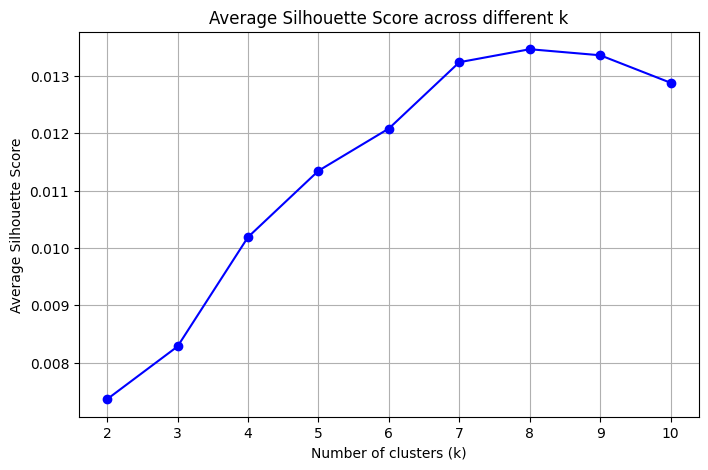

In [ ]:
# Hàm thực hiện phân cụm KMeans với k cụm, chạy n_init lần và trả về nhãn và điểm Silhouette mỗi lần
def cluster_quality_single_k(X, k, n_init=10):
    silhouette_scores = []  # Lưu điểm Silhouette của mỗi lần chạy
    cluster_labels = []     # Lưu nhãn phân cụm của mỗi lần chạy

    for _ in range(n_init):
        # Khởi tạo mô hình KMeans với k cụm, khởi tạo centroid theo k-means++, chạy 1 lần mỗi lần lặp
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=None)
        labels = kmeans.fit_predict(X)  # Chạy phân cụm và lấy nhãn cụm của từng điểm
        cluster_labels.append(labels)   # Lưu nhãn lần này
        score = silhouette_score(X, labels)  # Tính điểm Silhouette cho phân cụm này
        silhouette_scores.append(score)       # Lưu điểm Silhouette

    return cluster_labels, silhouette_scores  # Trả về danh sách nhãn và điểm Silhouette của tất cả lần chạy

# Phạm vi giá trị k thử từ 2 đến 10
k_values = range(2, 11)
n_init = 10  # Số lần chạy lại cho mỗi k để đánh giá ổn định và chất lượng
all_silhouette_dict = {}  # Lưu điểm Silhouette theo k
all_labels_dict = {}      # Lưu nhãn phân cụm theo k
avg_silhouette_scores = []  # Lưu điểm Silhouette trung bình cho mỗi k

# Duyệt từng giá trị k
for k in k_values:
    cluster_labels, silhouette_scores = cluster_quality_single_k(X, k, n_init=n_init)  # Phân cụm và tính điểm
    all_labels_dict[k] = cluster_labels          # Lưu nhãn phân cụm cho k
    all_silhouette_dict[k] = silhouette_scores   # Lưu điểm Silhouette cho k
    avg_score = np.mean(silhouette_scores)       # Tính điểm Silhouette trung bình cho k
    avg_silhouette_scores.append(avg_score)      # Lưu điểm trung bình
    print(f"k = {k}, Average Silhouette Score = {avg_score:.4f}")  # In điểm trung bình

# Tìm k có điểm Silhouette trung bình cao nhất
best_k_index = np.argmax(avg_silhouette_scores)  # Tìm index của điểm Silhouette lớn nhất
best_k = k_values[best_k_index]                   # Lấy giá trị k tương ứng
best_avg_score = avg_silhouette_scores[best_k_index]  # Lấy điểm Silhouette trung bình tốt nhất

print(f"\nSố lượng cụm tối ưu theo Silhouette Score là k = {best_k} với điểm trung bình = {best_avg_score:.4f}")

# Với k tốt nhất, lấy lần chạy có điểm Silhouette cao nhất trong n_init lần chạy
best_silhouette_scores = all_silhouette_dict[best_k]  # Lấy danh sách điểm Silhouette cho k tốt nhất
best_run_index = np.argmax(best_silhouette_scores)    # Tìm lần chạy có điểm cao nhất
best_labels = all_labels_dict[best_k][best_run_index] # Lấy nhãn phân cụm tương ứng

# Gắn nhãn cluster vào DataFrame gốc
df['cluster'] = best_labels

# Lưu DataFrame có cột cluster mới vào file CSV
df.to_csv(r'D:\Uni\TheThirdYear\kyii\Chinhthuctrentruong\dw\Final_Assignment_9_Group\Algorithms\k-means\data\original_data_with_cluster_k_{best_k}.csv', index=False)
print(f"Đã lưu kết quả phân cụm tốt nhất (k={best_k}, run={best_run_index+1}) vào file original_data_with_cluster_k_{best_k}.csv")

# Vẽ biểu đồ điểm Silhouette trung bình theo số cụm k
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_silhouette_scores, marker='o', color='b')
plt.title('Average Silhouette Score across different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

### Bước 7: Vẽ biểu đồ phân cụm

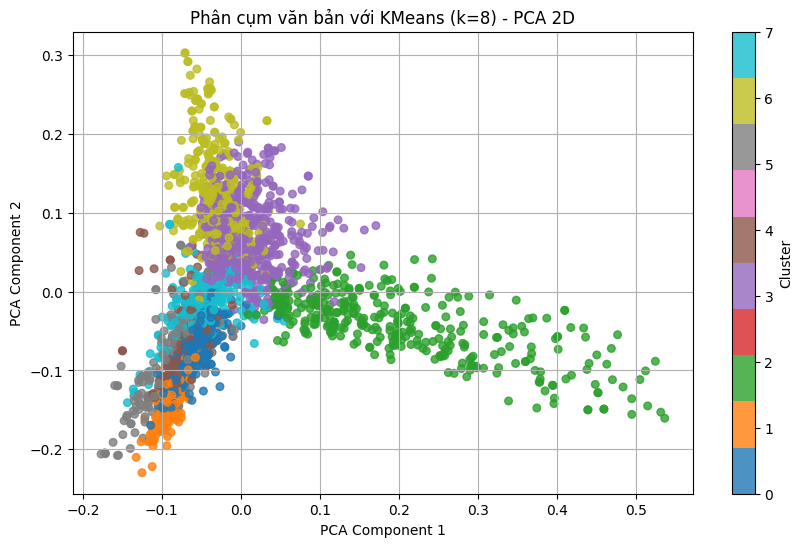

In [35]:
# Trực quan hóa phân cụm sau khi giảm chiều bằng PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='tab10', s=30, alpha=0.8)
plt.title(f'Phân cụm văn bản với KMeans (k={best_k}) - PCA 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()